# Regional Performance (Part 2)

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/tommy/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm
from collections import defaultdict

mpl.rcParams['figure.dpi'] = 150

In [3]:
label_size = 14  # 10
plt.rcParams.update(
    {'axes.labelsize': label_size,
     'legend.fontsize': label_size,
     "font.size": 14,
    }
)

In [4]:
# data_dir = Path('data/')
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [5]:
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

# Read in the CAMELS data

In [6]:
# read in the training data
ds = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")
ds['station_id'] = ds['station_id'].astype(int)

all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

# Read all predictions

In [7]:
from scripts.drafts.io_results import read_ensemble_results, read_fuse_data
from scripts.drafts.delta_error import DeltaError
SAVE = False
RELOAD = False

if RELOAD:
    pet_ealstm_ensemble_dir = data_dir / "runs/ensemble_pet_ealstm"
    ealstm_preds = read_ensemble_results(pet_ealstm_ensemble_dir)

    lstm_ensemble_dir = data_dir / "runs/ensemble_pet"
    lstm_preds = read_ensemble_results(lstm_ensemble_dir)

    raw_fuse_path = data_dir / "RUNOFF/FUSE"
    fuse_data = read_fuse_data(raw_fuse_path, lstm_preds["obs"])

    # get matching stations
    all_stations_lstm = np.isin(lstm_preds.station_id, fuse_data.station_id)
    all_stations_ealstm = np.isin(ealstm_preds.station_id, fuse_data.station_id)
    lstm_preds = lstm_preds.sel(
        station_id=all_stations_lstm, time=np.isin(lstm_preds.time, fuse_data.time)
    )
    ealstm_preds = ealstm_preds.sel(
        station_id=all_stations_ealstm, time=np.isin(ealstm_preds.time, fuse_data.time)
    )

    processor = DeltaError(
        ealstm_preds,
        lstm_preds,
        fuse_data,
        benchmark_calculation_ds=ds[["discharge_spec"]],
        incl_benchmarks=True,
    )
    all_preds = processor.all_preds
    
    if SAVE:
        all_preds.to_netcdf(data_dir / "RUNOFF/all_preds.nc")

else:
    all_preds = xr.open_dataset(data_dir / "RUNOFF/all_preds.nc")
    
# all_preds

In [74]:
import pickle
from scripts.drafts.calculate_error_scores import calculate_all_data_errors, get_metric_dataframes_from_output_dict

RELOAD = False

if RELOAD:
    all_errors = calculate_all_data_errors(all_preds, decompose_kge=True)
    all_metrics = get_metric_dataframes_from_output_dict(all_errors)
    if SAVE:
        pickle.dump(all_errors, (data_dir / "RUNOFF/all_errors.pkl").open("wb"))
        pickle.dump(all_metrics, (data_dir / "RUNOFF/all_metrics.pkl").open("wb"))
    
else:
    all_errors = pickle.load((data_dir / "RUNOFF/all_errors.pkl").open("rb"))
    all_metrics = pickle.load((data_dir / "RUNOFF/all_metrics.pkl").open("rb"))
    
all_metrics.keys()

all_metrics["bias_error_pct"] = all_metrics["bias_error"] * 100
all_metrics["std_error_pct"] = all_metrics["std_error"] * 100

all_metrics.keys()

metrics_xr = xr.Dataset(all_metrics).rename({"dim_1": "model"})

# ∆ Metrics

In [9]:
from scripts.drafts.calculate_error_scores import calculate_all_delta_dfs

In [10]:
lstm_delta, ealstm_delta = calculate_all_delta_dfs(
    all_metrics,
    absolute_metrics=[
            "fms",
            "flv",
            "fhv",
            "bias_error",
            "bias_error_pct",
            "std_error",
            "std_error_pct",
        ],
)

# Seasonal

In [90]:
import pickle 

seasonal_errors = pickle.load((data_dir / "RUNOFF/seasonal_errors.pkl").open("rb"))
seasonal_metrics = defaultdict(dict)
for season in ["DJF", "MAM", "JJA", "SON"]:
    seasonal_metrics[season] = get_metric_dataframes_from_output_dict(seasonal_errors[season])

In [91]:
season_xr = []

for season in ["DJF", "MAM", "JJA", "SON"]:
    d = xr.Dataset(seasonal_metrics[season])
    d = d.rename({"dim_1": "model"}).assign_coords(season=season).expand_dims(dim="season")
    season_xr.append(d)

season_xr = xr.merge(season_xr)

# Get Regional Predictions

In [12]:
import geopandas as gpd

# catchment shapefiles
shp_path = data_dir / "CAMELS_GB_DATASET/Catchment_Boundaries/CAMELS_GB_catchment_boundaries.shp"
assert shp_path.exists()

geo_df = gpd.read_file(shp_path)
geo_df['ID_STRING'] = geo_df['ID_STRING'].astype('int')
geo_df.crs = {'init' :'epsg:27700'}
geo_df.to_crs(epsg=4326)

# Station Gauge lat-lon points (already in EPSG:4326)
d = static[["gauge_lat", "gauge_lon"]].to_dataframe()
points = gpd.GeoSeries(gpd.points_from_xy(d["gauge_lon"], d["gauge_lat"]), index=d.index)
points.name = "geometry"

In [13]:
assert (data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp").exists(), "Download the natural earth hires from https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip"

world = gpd.read_file(data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp")
uk = world.query("ADM0_A3 == 'GBR'")
# uk.plot(facecolor='none', edgecolor='k')

In [14]:
catchment_ids = [int(c) for c in ["12002", "15006", "27009", "27034", "27041", "39001", "39081", "43021", "47001", "54001", "54057", "71001", "84013",]]
names = static["gauge_name"].to_dataframe()
poly = geo_df.set_index("ID").loc[catchment_ids].join(names).to_crs(epsg=4326)
all_poly = geo_df.set_index("ID").join(names).to_crs(epsg=4326)
pts = gpd.GeoDataFrame(points.loc[catchment_ids]).join(names)
all_points = gpd.GeoDataFrame(points).join(names)

## Regional Shapefiles

In [15]:
lakes = gpd.read_file(data_dir / "RUNOFF/gis_data_Tommy" / "UK_Lakes/UK_Lakes.shp").to_crs(epsg=4326)
hydro_regions = gpd.read_file(data_dir / "RUNOFF/gis_data_Tommy" / "UK_hydroclimate_regions_Harrigan_et_al_2018/UK_Hydro_Regions_ESP_HESS.shp").to_crs(epsg=4326)
hydro_regions = hydro_regions.loc[~np.isin(hydro_regions["NAME"], ["Northern Ireland", "Republic of Ireland"])]
aquifers = gpd.read_file(data_dir / "RUNOFF/gis_data_Tommy" / "Aquifers/Uk_HydroGeology_Simplified.shp").to_crs(epsg=4326)

In [16]:
region_abbrs = {
    'Western Scotland': "WS",
    'Eastern Scotland': "ES",
    'North-east England': "NEE",
    'Severn-Trent': "ST",
    'Anglian': "ANG",
    'Southern England': "SE",
    'South-west England & South Wales': "SWESW",
    'North-west England & North Wales (NWENW)': "NWENW",
}

def get_region_station_within(stations: gpd.GeoDataFrame, hydro_regions: gpd.GeoDataFrame):
    # find the region that a station belongs WITHIN
    # create a list of strings/nans for each station 
    region_dict = {}
    for region, geom in zip(hydro_regions["NAME"], hydro_regions["geometry"]):
        isin_region = ([p.within(geom) for p in stations])
        region_dict[region] = [(region if item else np.nan) for item in isin_region]

    region_cols = pd.DataFrame(region_dict)

    # copy non-null values from the right column into the left and select left
    # https://stackoverflow.com/a/49908660
    regions_list = (region_cols.bfill(axis=1).iloc[:, 0]).rename("region")
    regions_list.index = points.index

    return regions_list

In [82]:
regions_list = get_region_station_within(points, hydro_regions)
all_points = gpd.GeoDataFrame(points).join(names).join(regions_list)
regions_data = regions_list.to_frame().join(regions_list.map(region_abbrs).rename("region_abbr"))

if not (data_dir / "RUNOFF/regions_data.pkl").exists():
    pickle.dump(regions_data, (data_dir / "RUNOFF/regions_data.pkl").open("wb"))

In [98]:
def assign_region_coordinate(ds: xr.Dataset, regions_data: Optional[pd.DataFrame] = None):
    # get regions data
    if regions_data is None:
        regions_data = pickle.load((data_dir / "RUNOFF/regions_data.pkl").open("rb"))
    # convert to xarray
    region_xr = regions_data.to_xarray()
    # assign coordinate to ds
    ds = (
        ds
        .assign_coords(region=regions_data.to_xarray()["region"])
        .assign_coords(region=regions_data.to_xarray()["region_abbr"])
    ) 
    return ds

region_xr = regions_data.to_xarray()
metrics_xr = (
    metrics_xr
    .assign_coords(region=regions_data.to_xarray()["region"])
    .assign_coords(region_abbr=regions_data.to_xarray()["region_abbr"])
)

metrics_xr = assign_region_coordinate(metrics_xr)
season_xr = assign_region_coordinate(season_xr)

In [99]:
season_xr

<xarray.Dataset>
Dimensions:                 (model: 9, season: 4, station_id: 518)
Coordinates:
  * season                  (season) object 'DJF' 'JJA' 'MAM' 'SON'
  * station_id              (station_id) int64 1001 2001 2002 ... 102001 106001
  * model                   (model) object 'TOPMODEL' ... 'climatology_mon'
    region                  (station_id) object 'WS' 'WS' 'WS' ... 'NWENW' 'WS'
Data variables:
    sqrt_variability_ratio  (season, station_id, model) float64 0.9699 ... 0.3596
    inv_variability_ratio   (season, station_id, model) float64 0.9918 ... 0.1117
    variability_ratio       (season, station_id, model) float64 0.9022 ... 0.3089
    sqrt_correlation        (season, station_id, model) float64 0.7963 ... 0.3943
    inv_correlation         (season, station_id, model) float64 0.7551 ... 0.3672
    sqrt_bias_ratio         (season, station_id, model) float64 0.9558 ... 1.032
    inv_bias_ratio          (season, station_id, model) float64 1.099 ... 0.485
    abs_pct_bias            (season, station_id, model) float64 8.336 ... 7.067
    correlation             (season, station_id, model) float64 0.7611 ... 0.3237
    bias_error              (season, station_id, model) float64 -0.08336 ... -0.07067
    bias_ratio              (season, station_id, model) float64 0.9166 ... 0.9293
    std_error               (season, station_id, model) float64 -0.09779 ... -0.6911
    mam30_ape               (season, station_id, model) float64 32.14 ... 32.77
    sqrt_kge                (season, station_id, model) float64 0.7894 ... 0.1179
    log_nse                 (season, station_id, model) float64 0.5953 ... 0.1101
    inv_kge                 (season, station_id, model) float64 0.7357 ... -0.2061
    pbias                   (season, station_id, model) float64 8.336 ... 7.067
    bias                    (season, station_id, model) float64 -8.336 ... -7.067
    mape                    (season, station_id, model) float64 34.51 ... 123.7
    rmse                    (season, station_id, model) float64 1.366 ... 3.352
    nse                     (season, station_id, model) float64 0.5465 ... 0.09697
    kge                     (season, station_id, model) float64 0.7287 ... 0.03044
    mse                     (season, station_id, model) float64 1.865 ... 11.24

In [106]:
season_xr.where(season_xr.region == "WS", drop=True)["nse"]

<xarray.DataArray 'nse' (season: 4, station_id: 70, model: 9)>
array([[[ 5.46502238e-01,  5.89899029e-01,  6.12186056e-01, ...,
          4.17677684e-01,  2.95382229e-02, -1.81920671e-03],
        [ 4.09973242e-01,  5.22415001e-01,  5.27276776e-01, ...,
          1.90169552e-01,  1.56377118e-02, -6.93531329e-03],
        [ 5.21229699e-01,  5.38446559e-01,  5.14025494e-01, ...,
          3.02075504e-01,  3.06367363e-02,  3.29008606e-03],
        ...,
        [ 7.21127356e-01,  7.12493869e-01,  6.93533252e-01, ...,
         -2.59572333e-01,  2.51813891e-02,  5.24601015e-03],
        [ 5.06796411e-01,  5.11479844e-01,  5.05423835e-01, ...,
          2.78703886e-01,  2.33599639e-02, -5.59527529e-03],
        [ 7.94375179e-01,  8.37179435e-01,  8.43921876e-01, ...,
          6.30338065e-01,  6.40621231e-02,  1.90616916e-02]],

       [[ 6.75836000e-01,  6.64415862e-01,  6.67222554e-01, ...,
          4.22983569e-01,  2.23685313e-02, -9.02506765e-03],
        [ 7.76416044e-01,  6.69659525e-01,  6.76947700e-01, ...,
          2.29169527e-01,  9.79097352e-03, -7.15806470e-03],
        [ 7.67214363e-01,  6.95048332e-01,  7.47285086e-01, ...,
          3.79086418e-01,  1.54097106e-02, -3.10099191e-03],
        ...,
        [ 7.54309923e-01,  7.01590491e-01,  7.51901546e-01, ...,
         -9.11667663e-02,  2.42480404e-02, -2.86597034e-04],
        [ 7.46271925e-01,  6.76993384e-01,  7.57051606e-01, ...,
          3.80554729e-01,  7.04507922e-04, -1.73888891e-02],
        [ 5.91340204e-01,  6.60497089e-01,  5.95525400e-01, ...,
          4.65867378e-01,  2.70047749e-02, -7.55148549e-03]],

       [[ 6.61131677e-01,  6.95025415e-01,  7.14197603e-01, ...,
          5.13118715e-01,  2.01306710e-01,  1.51095646e-01],
        [ 5.06472523e-01,  5.64098742e-01,  5.66189955e-01, ...,
          4.49273706e-01,  1.33225996e-01,  9.71999953e-02],
        [ 5.78382700e-01,  5.90813922e-01,  5.74959795e-01, ...,
          5.78782742e-01,  1.76396978e-01,  1.01963652e-01],
        ...,
        [ 7.63429896e-01,  7.68592764e-01,  7.58812864e-01, ...,
         -8.52295419e-04,  1.20249468e-01,  4.89134705e-02],
        [ 6.18785935e-01,  5.96673436e-01,  6.12111653e-01, ...,
          4.97167526e-01,  1.37591399e-01,  1.12926192e-01],
        [ 8.25692840e-01,  8.38533783e-01,  8.37333659e-01, ...,
          7.26347075e-01,  2.91513443e-01,  1.86900041e-01]],

       [[ 8.25172408e-01,  8.20284214e-01,  8.51194309e-01, ...,
          5.47253363e-01,  2.25672226e-01,  1.68325616e-01],
        [ 7.94351097e-01,  7.72287937e-01,  7.70862264e-01, ...,
          2.13179045e-01,  1.10944512e-01,  8.60337035e-02],
        [ 8.05644594e-01,  7.59152216e-01,  7.93210547e-01, ...,
          3.16179855e-01,  1.32221321e-01,  8.55056048e-02],
        ...,
        [ 8.00895572e-01,  8.04925866e-01,  8.00364800e-01, ...,
         -1.42372250e-01,  7.37307112e-02,  2.63527303e-02],
        [ 7.74142954e-01,  8.11483643e-01,  7.63947076e-01, ...,
          2.93574043e-01,  1.43338857e-01,  1.08458360e-01],
        [ 7.70073427e-01,  8.17064756e-01,  8.00390728e-01, ...,
          5.57041009e-01,  2.06962031e-01,  9.69678151e-02]]])
Coordinates:
  * season      (season) object 'DJF' 'JJA' 'MAM' 'SON'
  * station_id  (station_id) int64 1001 2001 2002 3003 ... 96004 97002 106001
  * model       (model) object 'TOPMODEL' 'ARNOVIC' ... 'climatology_mon'
    region      (station_id) object 'WS' 'WS' 'WS' 'WS' ... 'WS' 'WS' 'WS' 'WS'

In [123]:
season_gdf = gpd.GeoDataFrame(season_xr.to_dataframe().reset_index(["model", "season"]).join(points))

# Regional tables

In [20]:
from typing import Dict, Optional, List

def get_region_and_UK_wide_metric(df: pd.DataFrame, agg: str = "median") -> pd.DataFrame:
    assert all(np.isin(["region", "LSTM"], df.columns))
    if agg == "median":
        # Median in each region
        med_region = df.groupby("region").median()[models]
        med_region.values.shape

        # Append Whole of UK Median (as a region)
        med_values = np.vstack([df.median()[models].values, med_region.values])

    elif agg == "mean":
        # Mean in each region
        med_region = df.groupby("region").mean()[models]
        med_region.values.shape

        # Append Whole of UK Median (as a region)
        med_values = np.vstack([df.mean()[models].values, med_region.values])
    else:
        assert False, "Only developed for two aggregation functions"
        
    region = ["UK"] + [region_abbrs[l] for l in med_region.index.values]
    columns = med_region.columns
    med_region = pd.DataFrame(med_values, columns=columns, index=region)
    return med_region


def plot_matrix_of_each_region_and_model(
    df: pd.DataFrame,
    ax: Optional = None,
    agg: str = "median",
    models: List[str] =  ['TOPMODEL', 'ARNOVIC', 'PRMS', 'SACRAMENTO', 'EALSTM', 'LSTM',],
    kwargs: Dict = {"cmap": "blues"}
):
    assert all(np.isin(["region", "region_abbr"], df.columns)), f"Expect [region region_abbr] to be in {df.columns}"
    assert agg in ["mean", "median"], "Expect agg to be one of median, mean"
    med_region = get_region_and_UK_wide_metric(df, agg=agg)
    
    if ax is None:
        # https://stackoverflow.com/a/40890587
        fig, ax = plt.subplots(figsize=(12, 8))

    intersection_matrix = med_region.values

    ax.imshow(intersection_matrix.T, **kwargs)

    for region_ix in range(intersection_matrix.shape[0]):
        for model_ix in range(intersection_matrix.shape[1]):
            c = intersection_matrix[region_ix, model_ix]
            ax.text(region_ix, model_ix, f"{c:.2f}", va='center', ha='center')

    ax.set_ylabel("Model")
    ax.set_xlabel("Region")
    ax.set_xticklabels([''] + list(med_region.index))
    ax.set_yticklabels([''] + list(med_region.columns))
    
    return ax

Text(0.5, 1.0, 'Median UK and Regional NSE')

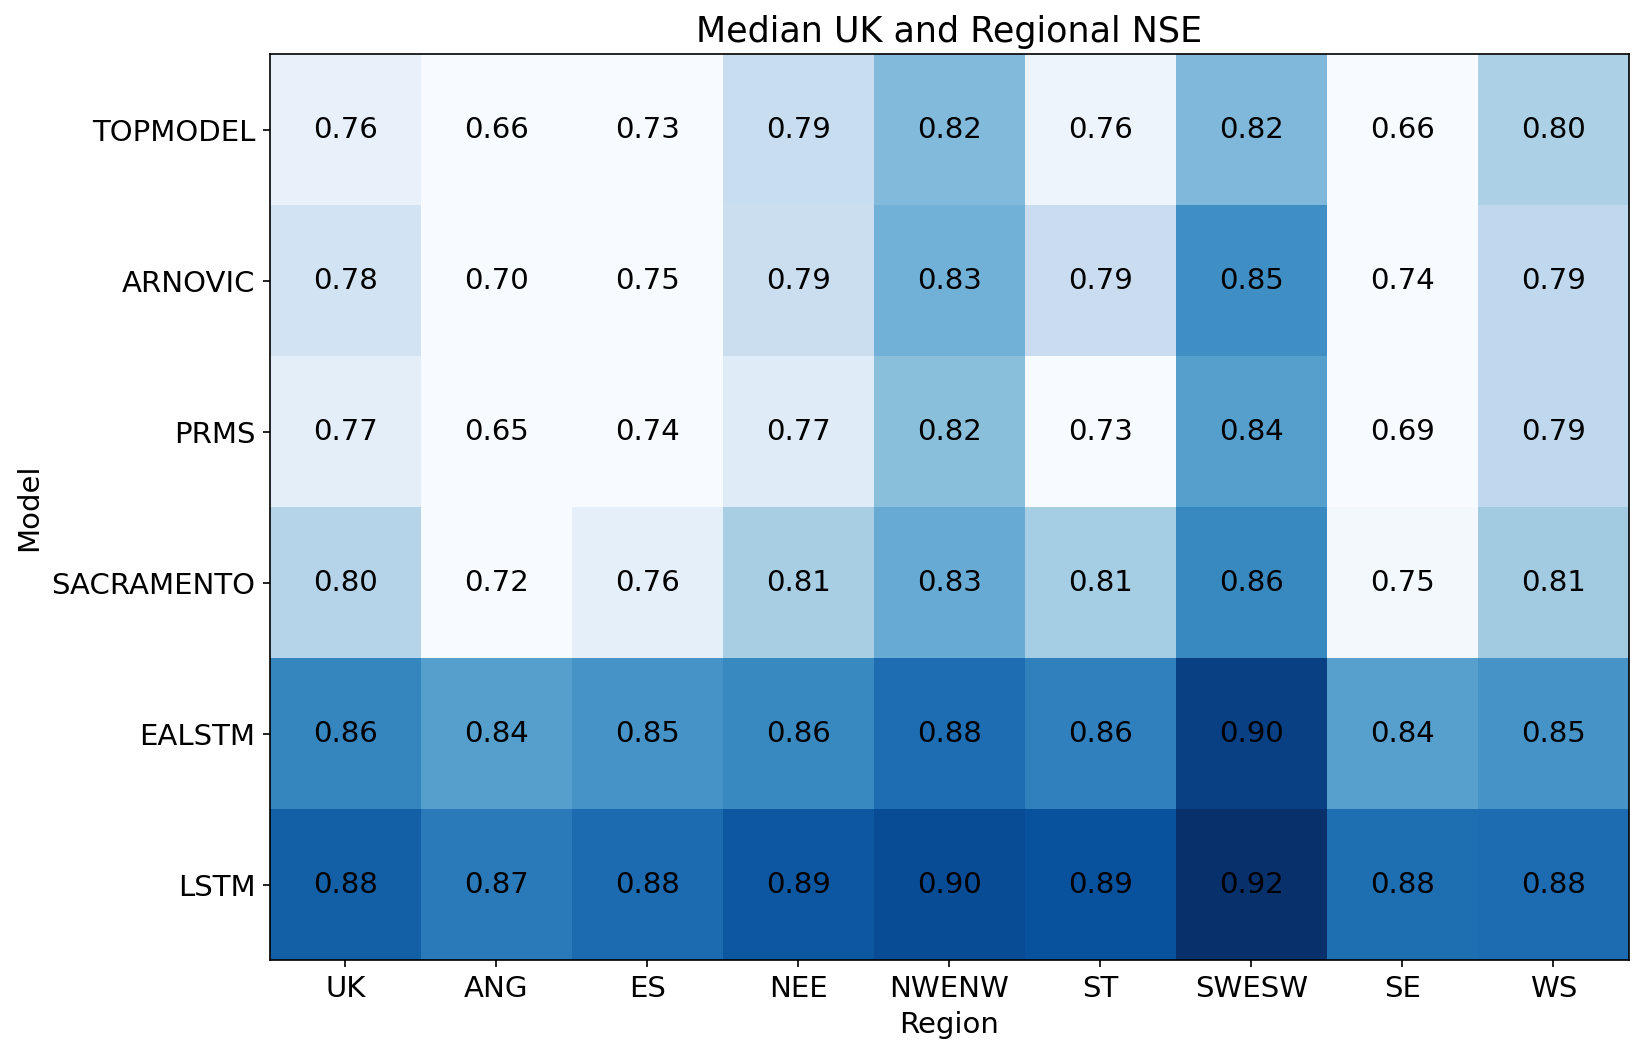

In [21]:
metric = "nse"
agg = "median"
skill_score = False
models: List[str] =  ['TOPMODEL', 'ARNOVIC', 'PRMS', 'SACRAMENTO', 'EALSTM', 'LSTM',]

metric_opts = dict(
    nse=dict(
        vmin = 0.75,
        vmax = None,
        cmap = "Blues",
        agg = "median",
    ),
    bias_error=dict(
        vmin = -0.15,
        vmax = 0.15,
        cmap = "RdBu",
        agg = "median",
    ),
    std_error=dict(
        vmin = -0.15,
        vmax = 0.15,
        cmap = "RdBu",
        agg = "median",
    ),
    correlation=dict(
        vmin = 0.85,
        vmax = 1,
        cmap = "plasma_r",
        agg = "median",
    ),
    flv=dict(
        vmin = -50,
        vmax = 50,
        cmap = "RdBu",
        agg = "median",
    ),
    fms=dict(
        vmin = -50,
        vmax = 50,
        cmap = "RdBu",
        agg = "median",
    ),
    fhv=dict(
        vmin = -18,
        vmax = 18,
        cmap = "RdBu",
        agg = "median",
    ),

)

# select metrics
df = region_metrics["nse"]
plot_matrix_of_each_region_and_model(df, agg="median", kwargs={"vmin": metric_opts[metric]["vmin"], "vmax": metric_opts[metric]["vmax"], "cmap": metric_opts[metric]["cmap"]})
ax = plt.gca()
ax.set_title(f"{agg.capitalize()} UK and Regional {metric.upper()}{'SS' if skill_score else ''}")

In [22]:
# metric = "std_error"

# # select metrics
# df = region_metrics[metric]
# plot_matrix_of_each_region_and_model(df, agg=agg, kwargs={"vmin": metric_opts[metric]["vmin"], "vmax": metric_opts[metric]["vmax"], "cmap": metric_opts[metric]["cmap"]})
# ax = plt.gca()
# ax.set_title(f"{agg.capitalize()} UK and Regional {metric.upper()}{'SS' if skill_score else ''}")

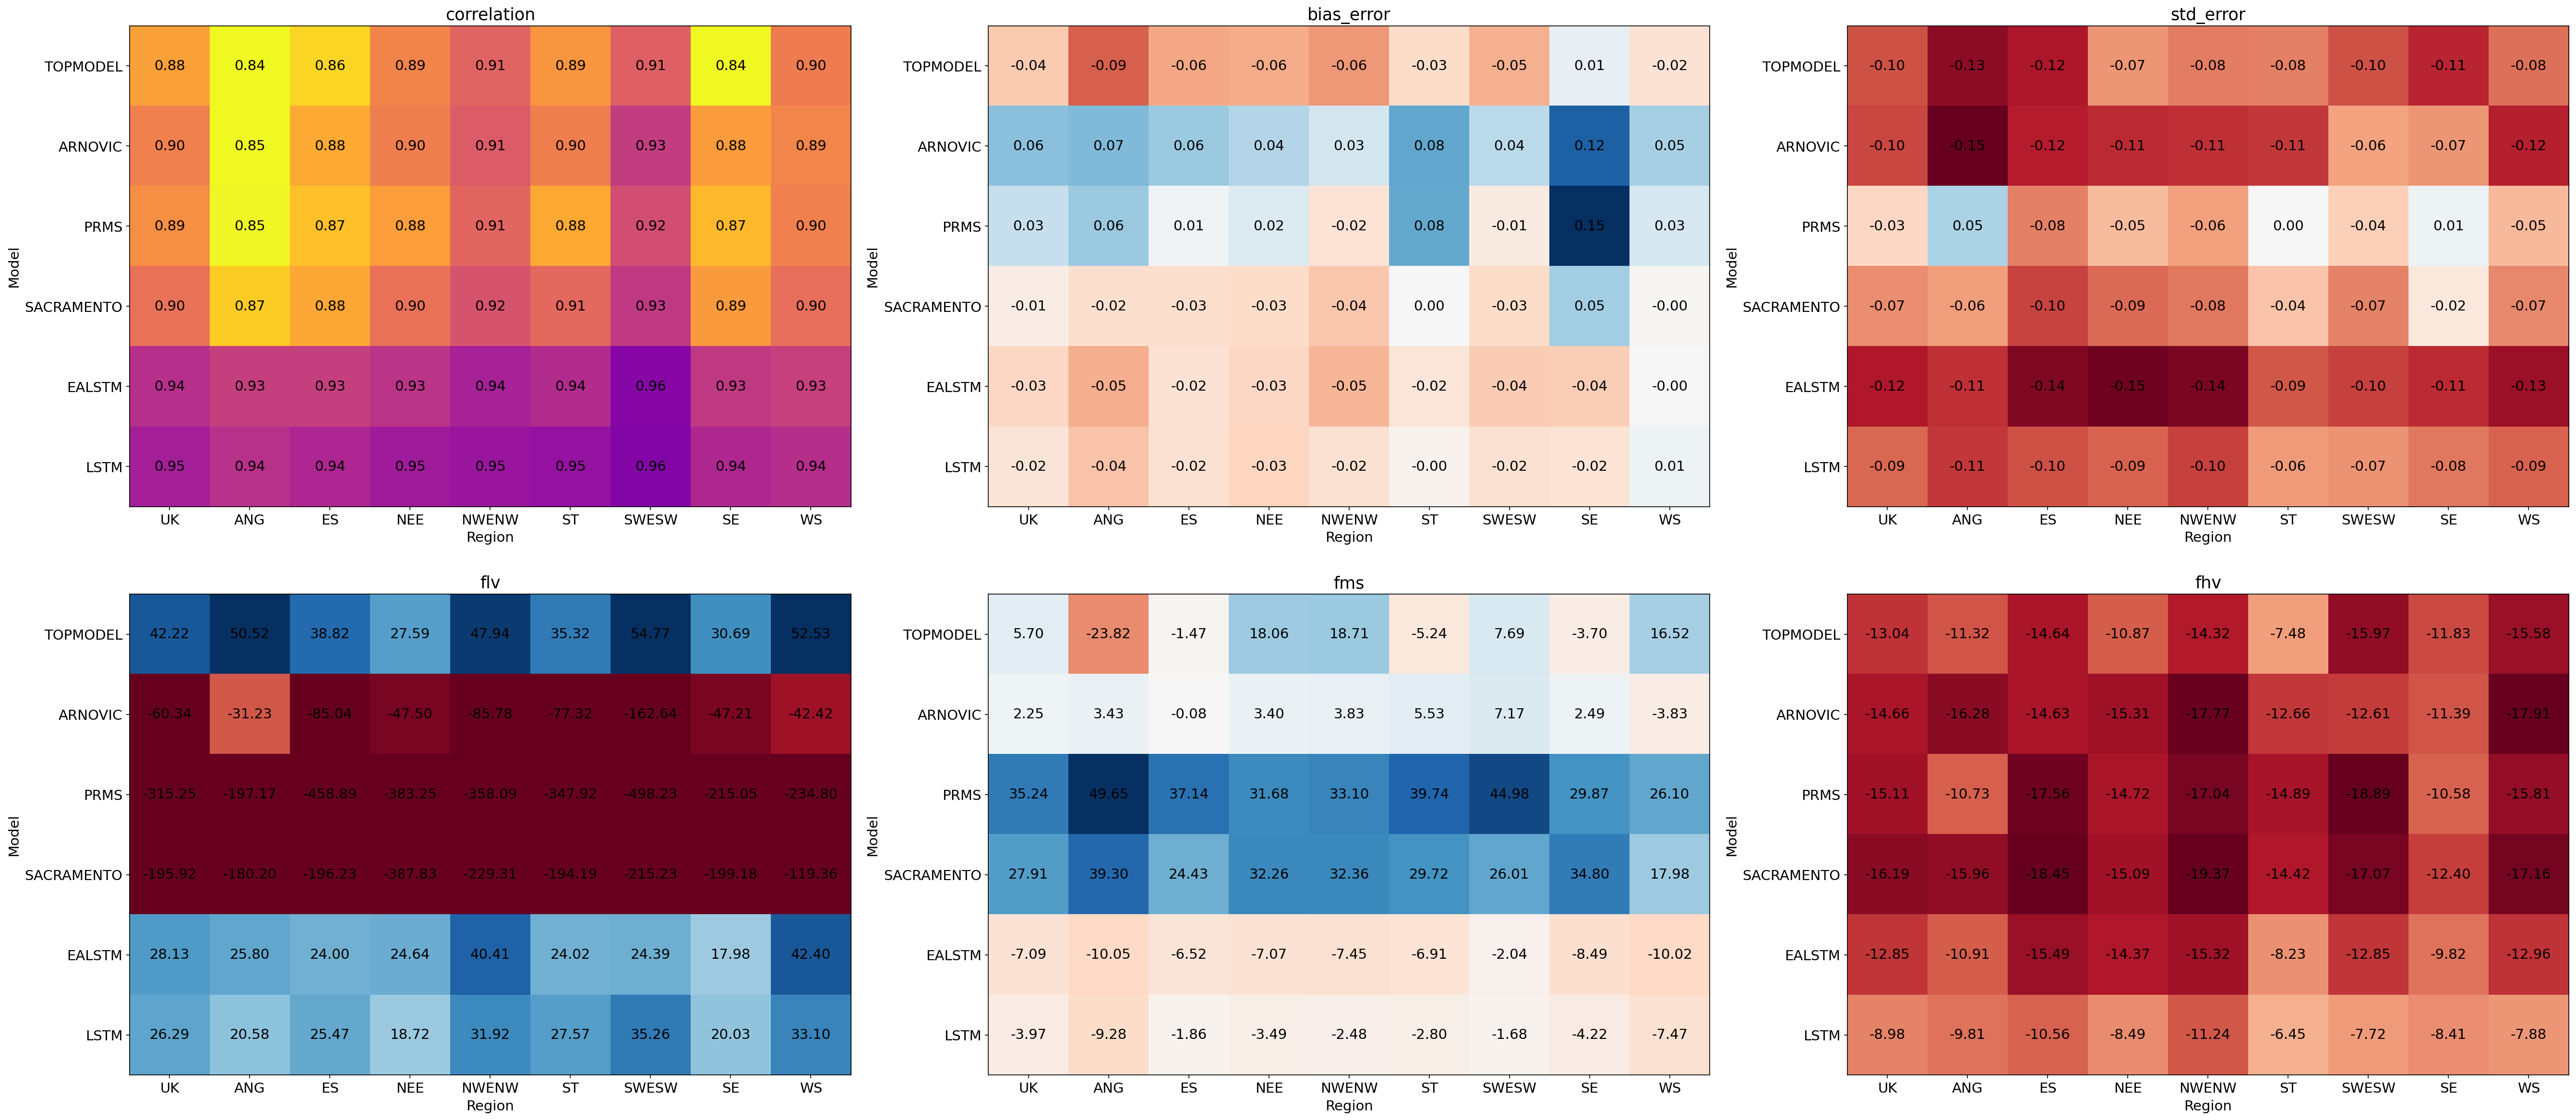

In [23]:
f, axs = plt.subplots(2, 3, figsize=(12*3, 8*2))

for ix, metric in enumerate(["correlation", "bias_error", "std_error", "flv", "fms", "fhv"]):
    ax = axs[np.unravel_index(ix, (2, 3))]

    # select metrics
    df = region_metrics[metric]

    plot_matrix_of_each_region_and_model(df, agg=agg, kwargs={"vmin": metric_opts[metric]["vmin"], "vmax": metric_opts[metric]["vmax"], "cmap": metric_opts[metric]["cmap"]}, ax=ax)
    ax.set_title(f"{metric}")

plt.tight_layout()

# Seasonal

In [26]:
season_medians = {}
for season in ["DJF", "MAM", "JJA", "SON"]:
    season_medians[season] = get_region_and_UK_wide_metric(region_season_metrics[season]["nse"]) # .groupby("region").median()

In [28]:
def calculate_difference_from_uk_average(df: pd.DataFrame):
    assert "UK" in df.index, "EXpect "
    assert "LSTM" in df.columns, "Expect models to be columns"

sesaon_deltas = defaultdict()

regions_all = []
for region in season_medians["DJF"].drop("UK").index:
    # calculate distance
    res = season_medians["DJF"].loc["UK"] - season_medians["DJF"].loc[region]
    res.name = region
    regions_all.append(res)

pd.concat(regions_all, axis=1)

,ANG,ES,NEE,NWENW,ST,SWESW,SE,WS
TOPMODEL,0.068505,0.098097,-0.014507,-0.061597,-0.006981,-0.061278,0.047372,-0.032248
ARNOVIC,0.092229,0.084902,0.003239,-0.056797,0.002199,-0.083223,0.037088,-0.006806
PRMS,0.121597,0.054122,0.015683,-0.069872,0.046826,-0.085695,0.039813,-0.023563
SACRAMENTO,0.044728,0.065353,0.007668,-0.046371,-0.020540,-0.072639,0.037798,0.004524
EALSTM,-0.006801,0.043590,0.005051,-0.018033,-0.015333,-0.039979,0.004623,0.015819
LSTM,0.010128,0.042305,0.000932,-0.013421,-0.015242,-0.026419,0.003741,0.010814


In [40]:
for key in region_season_metrics.keys():
    d = region_season_metrics[key]
    break
    


<xarray.Dataset>
Dimensions:                 (dim_1: 11, station_id: 518)
Coordinates:
  * station_id              (station_id) int64 1001 2001 2002 ... 102001 106001
  * dim_1                   (dim_1) object 'TOPMODEL' ... 'region_abbr'
Data variables:
    sqrt_variability_ratio  (station_id, dim_1) object 0.9699 0.7501 ... 'WS'
    inv_variability_ratio   (station_id, dim_1) object 0.9918 0.4593 ... 'WS'
    variability_ratio       (station_id, dim_1) object 0.9022 0.7467 ... 'WS'
    sqrt_correlation        (station_id, dim_1) object 0.7963 0.8316 ... 'WS'
    inv_correlation         (station_id, dim_1) object 0.7551 0.8639 ... 'WS'
    sqrt_bias_ratio         (station_id, dim_1) object 0.9558 1.083 ... 'WS'
    inv_bias_ratio          (station_id, dim_1) object 1.099 0.686 ... 'WS'
    abs_pct_bias            (station_id, dim_1) object 8.336 10.33 ... 'WS'
    correlation             (station_id, dim_1) object 0.7611 0.7815 ... 'WS'
    bias_error              (station_id, dim_1) object -0.08336 0.1033 ... 'WS'
    bias_ratio              (station_id, dim_1) object 0.9166 1.103 ... 'WS'
    std_error               (station_id, dim_1) object -0.09779 -0.2533 ... 'WS'
    mam30_ape               (station_id, dim_1) object 32.14 13.65 ... 'WS'
    sqrt_kge                (station_id, dim_1) object 0.7894 0.6874 ... 'WS'
    log_nse                 (station_id, dim_1) object 0.5953 0.625 ... 'WS'
    inv_kge                 (station_id, dim_1) object 0.7357 0.3601 ... 'WS'
    pbias                   (station_id, dim_1) object 8.336 -10.33 ... 'WS'
    bias                    (station_id, dim_1) object -8.336 10.33 ... 'WS'
    mape                    (station_id, dim_1) object 34.51 45.06 ... 'WS'
    rmse                    (station_id, dim_1) object 1.366 1.299 ... 'WS'
    nse                     (station_id, dim_1) object 0.5465 0.5899 ... 'WS'
    kge                     (station_id, dim_1) object 0.7287 0.6499 ... 'WS'
    mse                     (station_id, dim_1) object 1.865 1.686 ... 'WS'

NameError: name 'season_metrics' is not defined

In [ ]:
res